In [115]:
import geopandas as gpd

from pyproj import CRS, Transformer
import pyproj

import pandas as pd

# import some python packages
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import colors 
import warnings

from shapely.geometry import box, mapping, Point
from shapely.ops import transform


from pathlib import Path
import glob

# ignore some warnings
warnings.filterwarnings('ignore')
import scipy.signal

import rasterio
from rasterio.mask import mask


import seaborn as sns

import pickle

import matplotlib
matplotlib.rcParams.update({"pdf.fonttype":42})

# Set up

In [116]:
def fourier_2d_dem(z, step, bin_edges):
    # get the size of the raster and save a copy of the original grid
    z_original = z.copy()
    ny, nx = z.shape

    # use linear algebra to fit a plane by least squares
    x, y = np.meshgrid(range(nx), range(ny))
    A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
    fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
    z = z - (fit[0]*x + fit[1]*y + fit[2])

    # apply hanning windowing to reduce spectral leakage on edges
    hann_y = np.hanning(ny)
    hann_x = np.hanning(nx)
    hann_2d = np.sqrt(np.outer(hann_y, hann_x))
    hann_weight = np.sum(hann_2d ** 2)
    z = z * hann_2d

    # This next step is done to optimize the Cooley and Turkey (1965)
    # Discrete Fourier Transfom (DFT) method used by numpy, which operates
    # most efficiently when the length scales are powers of 2 and the grid
    # is square
    Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
    Ly = Lx

    # run the fft
    fft = np.fft.fftn(z, (Ly, Lx))

    # shift zero frequency to center
    fft_shift = np.fft.fftshift(fft)

    # # index of zero frequency (DC component)
    xc, yc = (Lx//2, Ly//2)

    # # zero out the DC component
    fft_shift[yc, xc] = 0

    # get the DFT periodogram with units of m^2 for topography
    # include weights of hann to correct for windowing
    p2d = np.abs(fft_shift)**2 / (Lx * Ly * hann_weight)

    # The periodogram is a measure of how much of the
    # original elevation field's variance falls within a given frequency range.
    # You can check that the sum of the periodogram is roughly equal to the
    # variance in Z. (The variance will be somewhat less due to the zero padding.)

    # calculate radial frequencies
    # xc, yc = (Lx//2, Ly//2) # (Lx//2 + 1, Ly//2 - 1) # center coordinate
    x, y = np.meshgrid(range(Lx), range(Ly))#[::-1])

    # wavenumbers
    kx = x - xc
    ky = y - yc
    # kx_, ky_ = np.meshgrid(range(-Lx//2, Lx//2 - 1), range(Ly//2, -Ly//2+1, -1))

    # radial frequencies
    fx = kx / (Lx * step)
    fy = ky / (Ly * step)
    f2d = np.sqrt(fx**2 + fy**2)
    # w2d = np.sqrt((1/fx)**2 + (1/fy)**2)
    # f2d = 1/w2d

    # fourier angles
    F_ang2d = np.rad2deg(np.arctan2(ky*step, kx*step))

    # Create sorted, non-redundant vectors of frequency and power
    p1d = p2d[:, 0:xc+1].copy() # only half the power (reflected across the center)
    f1d = f2d[:, 0:xc+1].copy() # same for the frequency
    F_ang1d = F_ang2d[:, 0:xc+1].copy() # same for angle

    # set reundant columns to negative for clipping below
    f1d[yc:Ly, xc] = -1

    # concatenate frequency and power and sort by frequency
    f1d = np.c_[f1d.ravel(), p1d.ravel(), F_ang1d.ravel()]
    I = np.argsort(f1d[:, 0])
    f1d = f1d[I, :]

    # remove negative values
    f1d = f1d[f1d[:, 0] > 0, :]

    # extract power, angle, and frequency (factor of 2 corrects for taking half the spectrum)
    p1d = 2 * f1d[:, 1] # the sum of the p2d and p1d should now be approximately equal
    F_ang1d = f1d[:, 2]
    f1d = f1d[:, 0]

    # bin the data using log bins
    # bins = 20
    # f_bins = np.logspace(np.log10(f1d.min()), np.log10(f1d.max()), num=bins)

    # a1=10.**(np.arange(-4, 0)) 
    # a2 = np.arange(1,10,0.5)
    # bin_edges=np.outer(a1, a2).flatten()

    bin_med, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmedian,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )
    bin_max, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmax,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )
    bin_center = edges[:-1] + np.diff(edges)/2

    # sometimes NaN values remain in some bins, throw those bins out
    bin_center = bin_center[np.isfinite(bin_med)]
    bin_med = bin_med[np.isfinite(bin_med)]
    bin_max = bin_max[np.isfinite(bin_max)]

    # apply a power-law fit to the bins
    A = np.vstack([np.log10(bin_center), np.ones(len(bin_center))]).T
    fit = np.linalg.lstsq(A, np.log10(bin_med), rcond=None)[0]
    pl_fit = (10**fit[1]) * (bin_center**fit[0])

    # use the power-law fit to normalize the 1D spectrum
    p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

    # Get max of normalized values
    norm_bin_max, edges, _ = stats.binned_statistic(f1d, p1d_norm, statistic=np.nanmax,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )

    norm_bin_max = norm_bin_max[np.isfinite(norm_bin_max)]

    return bin_center, bin_max, norm_bin_max 

In [117]:
def fourier_2d_nofit(z, step, bin_edges):
    # get the size of the raster and save a copy of the original grid
    z_original = z.copy()
    ny, nx = z.shape

    # # use linear algebra to fit a plane by least squares
    # x, y = np.meshgrid(range(nx), range(ny))
    # A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
    # fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
    # z = z - (fit[0]*x + fit[1]*y + fit[2])

    # apply hanning windowing to reduce spectral leakage on edges
    hann_y = np.hanning(ny)
    hann_x = np.hanning(nx)
    hann_2d = np.sqrt(np.outer(hann_y, hann_x))
    hann_weight = np.sum(hann_2d ** 2)
    z = z * hann_2d

    # This next step is done to optimize the Cooley and Turkey (1965)
    # Discrete Fourier Transfom (DFT) method used by numpy, which operates
    # most efficiently when the length scales are powers of 2 and the grid
    # is square
    Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
    Ly = Lx

    # run the fft
    fft = np.fft.fftn(z, (Ly, Lx))

    # shift zero frequency to center
    fft_shift = np.fft.fftshift(fft)

    # # index of zero frequency (DC component)
    xc, yc = (Lx//2, Ly//2)

    # # zero out the DC component
    fft_shift[yc, xc] = 0

    # get the DFT periodogram with units of m^2 for topography
    # include weights of hann to correct for windowing
    p2d = np.abs(fft_shift)**2 / (Lx * Ly * hann_weight)

    # The periodogram is a measure of how much of the
    # original elevation field's variance falls within a given frequency range.
    # You can check that the sum of the periodogram is roughly equal to the
    # variance in Z. (The variance will be somewhat less due to the zero padding.)

    # calculate radial frequencies
    # xc, yc = (Lx//2, Ly//2) # (Lx//2 + 1, Ly//2 - 1) # center coordinate
    x, y = np.meshgrid(range(Lx), range(Ly))#[::-1])

    # wavenumbers
    kx = x - xc
    ky = y - yc
    # kx_, ky_ = np.meshgrid(range(-Lx//2, Lx//2 - 1), range(Ly//2, -Ly//2+1, -1))

    # radial frequencies
    fx = kx / (Lx * step)
    fy = ky / (Ly * step)
    f2d = np.sqrt(fx**2 + fy**2)
    # w2d = np.sqrt((1/fx)**2 + (1/fy)**2)
    # f2d = 1/w2d

    # fourier angles
    F_ang2d = np.rad2deg(np.arctan2(ky*step, kx*step))

    # Create sorted, non-redundant vectors of frequency and power
    p1d = p2d[:, 0:xc+1].copy() # only half the power (reflected across the center)
    f1d = f2d[:, 0:xc+1].copy() # same for the frequency
    F_ang1d = F_ang2d[:, 0:xc+1].copy() # same for angle

    # set reundant columns to negative for clipping below
    f1d[yc:Ly, xc] = -1

    # concatenate frequency and power and sort by frequency
    f1d = np.c_[f1d.ravel(), p1d.ravel(), F_ang1d.ravel()]
    I = np.argsort(f1d[:, 0])
    f1d = f1d[I, :]

    # remove negative values
    f1d = f1d[f1d[:, 0] > 0, :]

    # extract power, angle, and frequency (factor of 2 corrects for taking half the spectrum)
    p1d = 2 * f1d[:, 1] # the sum of the p2d and p1d should now be approximately equal
    F_ang1d = f1d[:, 2]
    f1d = f1d[:, 0]

    # bin the data using log bins
    # bins = 20
    # f_bins = np.logspace(np.log10(f1d.min()), np.log10(f1d.max()), num=bins)

    # a1=10.**(np.arange(-4, 0)) 
    # a2 = np.arange(1,10,0.5)
    # bin_edges=np.outer(a1, a2).flatten()

    bin_med, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmedian,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )
    bin_max, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmax,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )
    bin_center = edges[:-1] + np.diff(edges)/2

    # sometimes NaN values remain in some bins, throw those bins out
    bin_center = bin_center[np.isfinite(bin_med)]
    bin_med = bin_med[np.isfinite(bin_med)]
    bin_max = bin_max[np.isfinite(bin_max)]

    # apply a power-law fit to the bins
    A = np.vstack([np.log10(bin_center), np.ones(len(bin_center))]).T
    fit = np.linalg.lstsq(A, np.log10(bin_med), rcond=None)[0]
    pl_fit = (10**fit[1]) * (bin_center**fit[0])

    # use the power-law fit to normalize the 1D spectrum
    p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

    # Get max of normalized values
    norm_bin_max, edges, _ = stats.binned_statistic(f1d, p1d_norm, statistic=np.nanmax,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )

    norm_bin_max = norm_bin_max[np.isfinite(norm_bin_max)]

    return bin_center, bin_max, norm_bin_max 

In [118]:
def derive_curvature(elevation, window_size):
    # Compute first derivatives with a moving window
    dx = scipy.signal.convolve2d(elevation, np.array([[-1, 0, 1]]), mode='same') / 2
    dy = scipy.signal.convolve2d(elevation, np.array([[-1], [0], [1]]), mode='same') / 2

    # Compute second derivatives with a moving window
    dxx = scipy.signal.convolve2d(dx, np.array([[-1, 0, 1]]), mode='same') / 2
    dyy = scipy.signal.convolve2d(dy, np.array([[-1], [0], [1]]), mode='same') / 2

    # Calculate curvature
    curvature = (dxx + dyy) / (1 + dx**2 + dy**2)**1.5

    return curvature

In [119]:
bin_edges = np.flip(1/(np.linspace(10,151,50)))
# bin_edges

In [120]:
bin_edges = bin_edges[bin_edges < 0.33]

In [121]:
p = Path('../downloaded-arcticdem/agu_lsdtt/')
id_list = [int(f.name) for f in p.iterdir() if f.is_dir()]

len(id_list)

981

# Run the thing (long)

In [21]:
id_dict={}

for i, id in enumerate(id_list):
    print(f'{i} of {len(id_list)}')
    data_dict = {}

    with rasterio.open(f'../downloaded-arcticdem/agu_lsdtt/{id}/{id}.tif') as src:
        elevation = np.ma.masked_equal(src.read(1), -0.)
        bin_center, bin_max, norm_bin_max = fourier_2d_dem(elevation, 2, bin_edges)
        
        data_dict['bin_max'] = bin_max
        data_dict['norm_bin_max'] = norm_bin_max
        data_dict['bin_center'] = bin_center

        curvature = derive_curvature(elevation, 20)

        bin_center, bin_max, norm_bin_max = fourier_2d_nofit(curvature, 2, bin_edges)

        data_dict['curv_bin_max'] = bin_max
        data_dict['curv_norm_bin_max'] = norm_bin_max
        data_dict['curv_bin_center'] = bin_center

        id_dict[id] = data_dict

0 of 981
1 of 981
2 of 981
3 of 981
4 of 981
5 of 981
6 of 981
7 of 981
8 of 981
9 of 981
10 of 981
11 of 981
12 of 981
13 of 981
14 of 981
15 of 981
16 of 981
17 of 981
18 of 981
19 of 981
20 of 981
21 of 981
22 of 981
23 of 981
24 of 981
25 of 981
26 of 981
27 of 981
28 of 981
29 of 981
30 of 981
31 of 981
32 of 981
33 of 981
34 of 981
35 of 981
36 of 981
37 of 981
38 of 981
39 of 981
40 of 981
41 of 981
42 of 981
43 of 981
44 of 981
45 of 981
46 of 981
47 of 981
48 of 981
49 of 981
50 of 981
51 of 981
52 of 981
53 of 981
54 of 981
55 of 981
56 of 981
57 of 981
58 of 981
59 of 981
60 of 981
61 of 981
62 of 981
63 of 981
64 of 981
65 of 981
66 of 981
67 of 981
68 of 981
69 of 981
70 of 981
71 of 981
72 of 981
73 of 981
74 of 981
75 of 981
76 of 981
77 of 981
78 of 981
79 of 981
80 of 981
81 of 981
82 of 981
83 of 981
84 of 981
85 of 981
86 of 981
87 of 981
88 of 981
89 of 981
90 of 981
91 of 981
92 of 981
93 of 981
94 of 981
95 of 981
96 of 981
97 of 981
98 of 981
99 of 981
100 of 981

In [23]:
# save dictionary to person_data.pkl file
with open('id_dict_10s_wls.pkl', 'wb') as fp:
    pickle.dump(id_dict, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


# Load data

In [144]:
id_dict = pickle.load(open('id_dict_wavelengths.pkl', 'rb'))
data = pickle.load(open('id_dict_10s_wls.pkl', 'rb'))

In [145]:
1/id_dict[3100132040]['bin_center']

array([4.44444444e+03, 2.40000000e+03, 1.33333333e+03, 9.47368421e+02,
       8.47058824e+02, 7.46666667e+02, 6.46153846e+02, 5.45454545e+02,
       4.44444444e+02, 3.42857143e+02, 2.40000000e+02, 1.33333333e+02,
       9.47368421e+01, 8.47058824e+01, 7.46666667e+01, 6.46153846e+01,
       5.45454545e+01, 4.44444444e+01, 3.42857143e+01, 2.40000000e+01,
       1.33333333e+01, 9.47368421e+00, 8.47058824e+00, 7.46666667e+00,
       6.46153846e+00, 5.45454545e+00, 4.44444444e+00, 3.42857143e+00,
       2.40000000e+00])

In [146]:
1/data[3100132040]['bin_center']

array([149.5473835 , 146.66956096, 143.79172755, 140.9138826 ,
       138.03602541, 135.15815518, 132.28027106, 129.40237213,
       126.52445738, 123.6465257 , 120.76857588, 117.89060659,
       115.01261638, 112.13460364, 109.25656657, 106.37850322,
       103.50041138, 100.62228862,  97.7441322 ,  94.86593906,
        91.98770576,  89.10942841,  86.23110259,  83.35272329,
        80.47428478,  77.59578047,  74.71720276,  71.83854283,
        68.95979039,  66.08093338,  63.2019575 ,  60.32284576,
        57.44357775,  54.56412877,  51.68446862,  48.80455997,
        45.92435616,  43.04379805,  40.1628096 ,  37.28129131,
        34.39911043,  31.51608585,  28.63196384,  25.74637757,
        22.85877624,  19.96829316,  17.0734815 ,  14.17173113,
        11.25780553])

8100006660 is empty
3100349510 is empty
2100232610 is empty


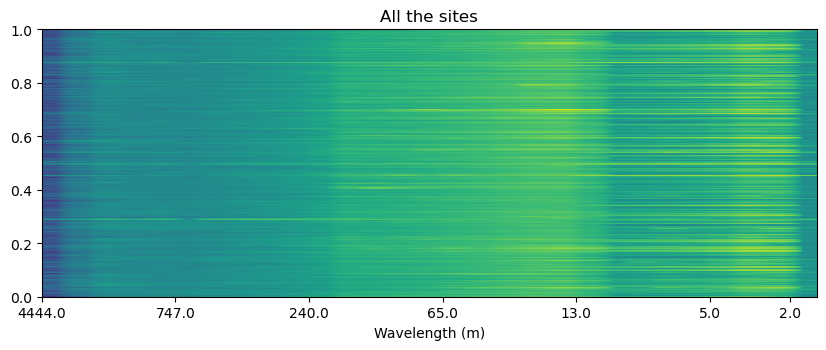

In [133]:
fig, ax = plt.subplots(figsize=(10,5))
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in id_list:
    if id_dict[site]['norm_bin_max'].size != 0:    
        array_list.append(id_dict[site]['norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)

from matplotlib import colors 
ax.imshow(array, extent=[0,len(id_dict[id_list[0]]['bin_center']),0,1], aspect=10, norm = colors.LogNorm())
# ax.set_ylabel('Sites ordered by MAT (1.0=cold)(i think)')
ax.set_xlabel('Wavelength (m)')
ax.set_title('All the sites')

ax.set_xticks([0, 5, 10, 15, 20, 25, 28])
ax.set_xticklabels(np.round(1/np.array([id_dict[id_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()]),0));
# ax.set_xticklabels(np.round(1/np.array([id_dict[id_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()[:-1]]),0));

8100006660 is empty
3100349510 is empty
2100232610 is empty


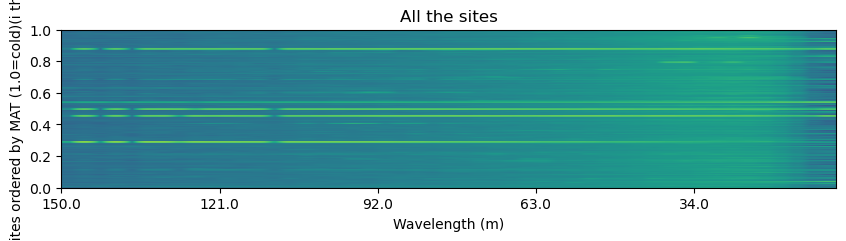

In [161]:
fig, ax = plt.subplots(figsize=(10,5))
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in id_list:
    if data[site]['norm_bin_max'].size != 0:    
        array_list.append(data[site]['norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)


ax.imshow(array, extent=[0,len(data[id_list[0]]['bin_center']),0,1], aspect=10, norm = colors.LogNorm())
ax.set_ylabel('Sites ordered by MAT (1.0=cold)(i think)')
ax.set_xlabel('Wavelength (m)')
ax.set_title('All the sites')

# ax.set_xticks(ax.get_xticks()[:-1])
ax.set_xticklabels(np.round(1/np.array([data[id_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()[:-1]]),0));

In [ ]:
# # save dictionary to person_data.pkl file
# with open('id_dict_wavelengths.pkl', 'wb') as fp:
#     pickle.dump(id_dict, fp)
#     print('dictionary saved successfully to file')

dictionary saved successfully to file


In [135]:
# import pickle
# data = pickle.load(open('id_dict_wavelengths.pkl', 'rb'))

# Bring in dataframe

In [147]:
df = pd.read_csv('spectra_wavelength_powers.csv')
d1 = pd.read_csv('veg_cluster_sheds.csv').drop('Unnamed: 0', axis=1)
d2 = pd.read_csv('noperm_veg_cluster_sheds.csv').drop('Unnamed: 0', axis=1)
cluster = pd.concat([d1, d2])
shedventory = pd.read_csv('shedventory_2.0.1_GIA.csv')
shedventory = pd.merge(cluster, shedventory, on='HYBAS_ID')
shedventory = pd.merge(df, shedventory, on='HYBAS_ID')
shedventory = shedventory.drop_duplicates()
simplified_dict = {
    'Sporadic':'Patchy',
    'Isolated':'Patchy', 
    'Discontinuous':'Extensive',
    'Continuous':'Extensive',
    'No permafrost':'No permafrost'
}

shedventory['simple'] = shedventory['EXTENT'].map(simplified_dict)

In [148]:
shedventory = shedventory.loc[shedventory['relief']>20]

In [173]:
mat_sorted_list = shedventory.sort_values(by='mat_mean')['HYBAS_ID'].to_list()
relief_sorted_list = shedventory.sort_values(by='relief')['HYBAS_ID'].to_list()
mat_tundra_sorted_list = shedventory.loc[shedventory['cluster']==2].sort_values(by='mat_mean')['HYBAS_ID'].to_list()
mat_boreal_sorted_list = shedventory.loc[shedventory['cluster']==1].sort_values(by='mat_mean')['HYBAS_ID'].to_list()
relief_tundra_sorted_list = shedventory.loc[shedventory['cluster']==2].sort_values(by='relief')['HYBAS_ID'].to_list()

In [150]:
shedventory['max_power'] = shedventory['HYBAS_ID'].map(lambda x: max(data.get(x, {}).get('norm_bin_max', [])))
shedventory['log_max_power'] = np.log(shedventory['max_power'])
# shedventory.columns

In [151]:
gdf = gpd.GeoDataFrame(
    shedventory, geometry=gpd.points_from_xy(shedventory.long, shedventory.lat), crs='epsg:4326')

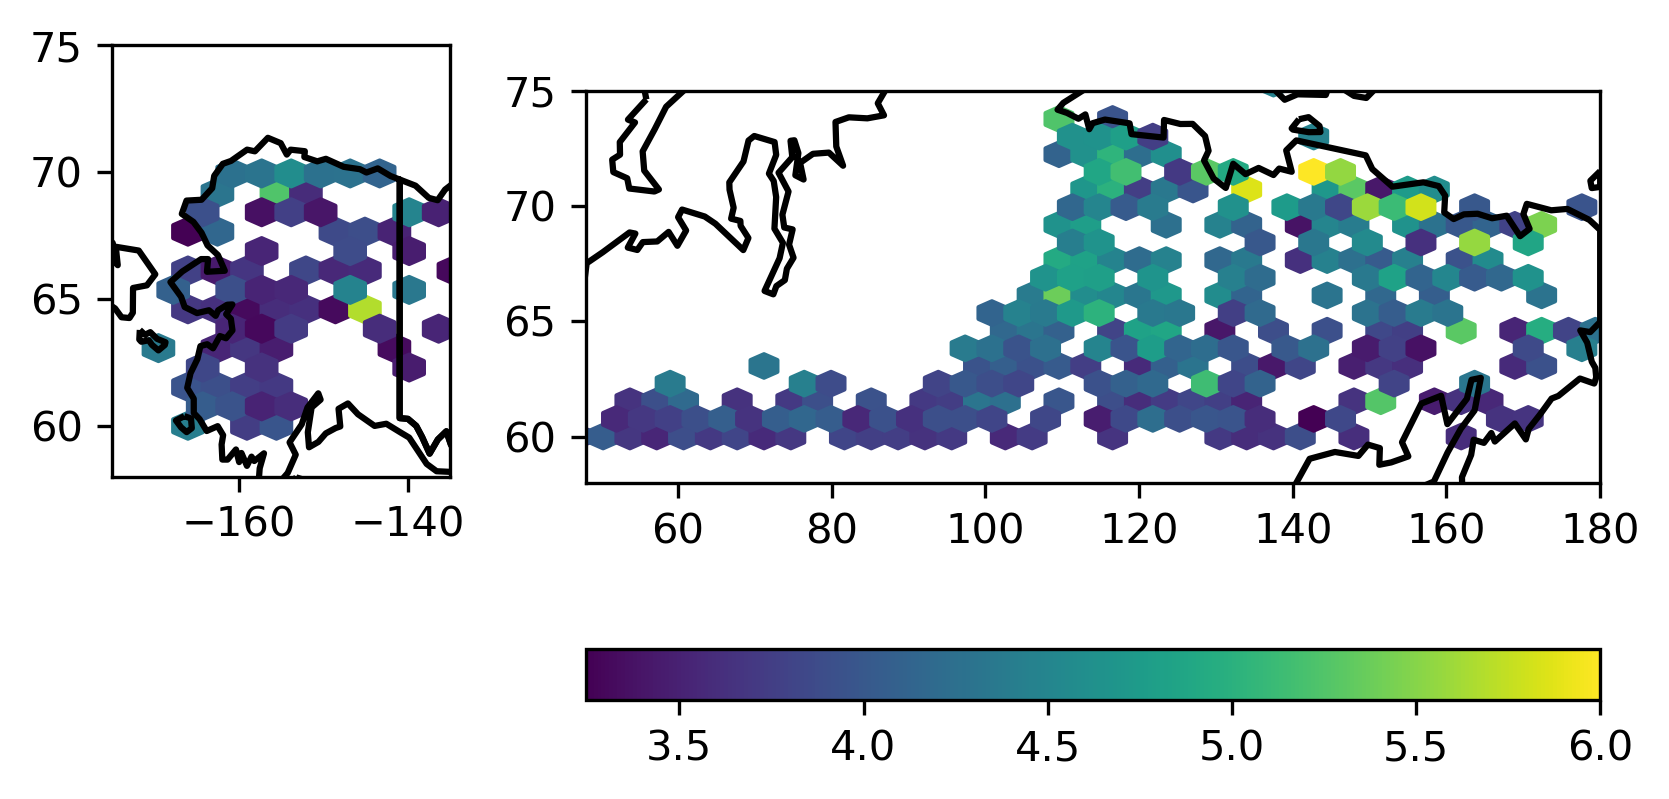

In [239]:
# GeoPandas has a simple map of the Earth built in
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(
    1,2,
    # figsize=(5,5),
    dpi=300,
    gridspec_kw={'width_ratios': [1, 3]}
    )
im = world.boundary.plot(
    # color=None, 
    edgecolor='black', ax=ax[0]),
alpha=0.2,
zorder=1
# im2 = gdf.plot(
#     ax=ax,
#     column='log_max_power',
#     s=2
# )

hb = ax[0].hexbin(x=gdf['long'], y=gdf['lat'], C=gdf['log_max_power'],
            #    , gridsize=50,
            gridsize=(100,10),
            #  cmap='viridis', edgecolors='gray', 
            reduce_C_function=np.max,
            zorder=0
               )
ax[0].set_aspect(3)
ax[0].set_ylim(58,75)
ax[0].set_xlim(-175,-135)

im = world.boundary.plot(
    # color=None, 
    edgecolor='black', ax=ax[1]),
alpha=0.2,
zorder=1
# im2 = gdf.plot(
#     ax=ax,
#     column='log_max_power',
#     s=2
# )

hb = ax[1].hexbin(x=gdf['long'], y=gdf['lat'], C=gdf['log_max_power'],
            #    , gridsize=50,
            gridsize=(100,10),
            #  cmap='viridis', edgecolors='gray', 
            reduce_C_function=np.median,
            zorder=0,
            vmax=6,

               )
ax[1].set_aspect(3)
ax[1].set_ylim(58,75)
ax[1].set_xlim(48, 180)
plt.colorbar(hb, orientation='horizontal')
# cbar = plt.colorbar(hb, ax=ax, label='Log median normalized power of 10s wavelength bin', orientation='horizontal')
plt.savefig('figs/map_of_10s_powers.pdf', bbox_inches='tight')

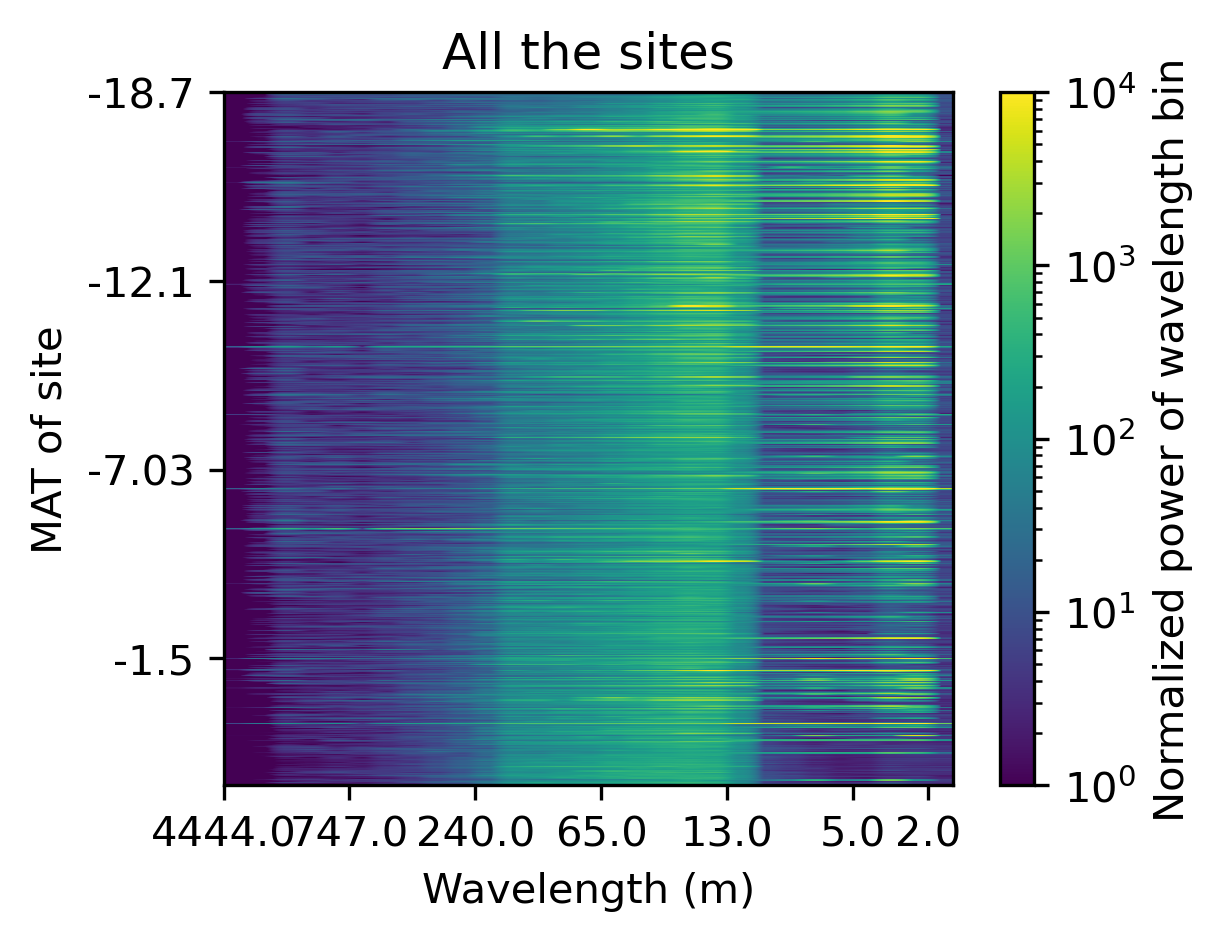

In [304]:
fig, ax = plt.subplots(figsize=(4,3), dpi=300)
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in mat_sorted_list:
    if id_dict[site]['norm_bin_max'].size != 0:    
        array_list.append(id_dict[site]['norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)

from matplotlib import colors 
im = ax.imshow(array, extent=[0,len(id_dict[id_list[0]]['bin_center']),len(shedventory.sort_values(by='mat_mean')['mat_mean'].values), 0], aspect=0.03, 
            norm = colors.LogNorm(
               vmin=1e0,
               vmax=1e4
           )
)
        
          
ax.set_ylabel('MAT of site')
ax.set_xlabel('Wavelength (m)')
ax.set_title('All the sites')

ax.set_xticks([0, 5, 10, 15, 20, 25, 28])
ax.set_xticklabels(np.round(1/np.array([id_dict[id_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()]),0));

ax.set_yticks([0,250,500,750])
ax.set_yticklabels((np.round(shedventory.sort_values(by='mat_mean')['mat_mean'].values,2)[int(tick)] for tick in ax.get_yticks()));

cbar = plt.colorbar(im, ax=ax, label='Normalized power of wavelength bin')

plt.savefig('figs/heatmap_of_all_powers.pdf', bbox_inches='tight')

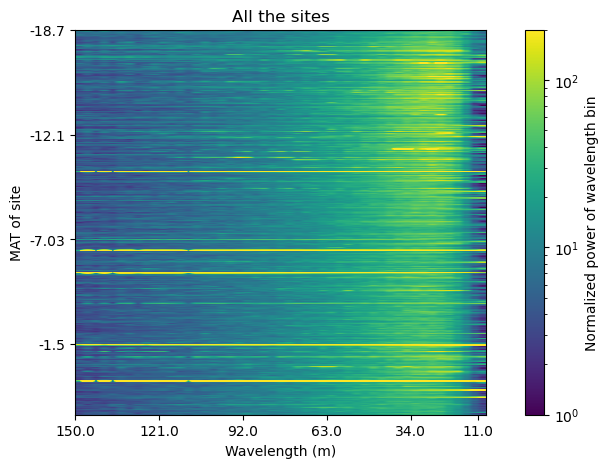

In [241]:
fig, ax = plt.subplots(figsize=(10,5))
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in mat_sorted_list:
    if data[site]['norm_bin_max'].size != 0:    
        array_list.append(data[site]['norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)

from matplotlib import colors 
im = ax.imshow(array, extent=[0,len(data[id_list[0]]['bin_center']),len(shedventory.sort_values(by='mat_mean')['mat_mean'].values), 0], aspect=0.05, 
            norm = colors.LogNorm(
               vmin=1e0,
               vmax=2e2
           )
)
        
          
ax.set_ylabel('MAT of site')
ax.set_xlabel('Wavelength (m)')
ax.set_title('All the sites')

ax.set_xticks([0, 10, 20, 30, 40, 48])
ax.set_xticklabels(np.round(1/np.array([data[id_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()]),0));

ax.set_yticks([0,250,500,750])
ax.set_yticklabels((np.round(shedventory.sort_values(by='mat_mean')['mat_mean'].values,2)[int(tick)] for tick in ax.get_yticks()));
cbar = plt.colorbar(im, ax=ax, label='Normalized power of wavelength bin')

plt.savefig('figs/heatmap_of_10s_powers.pdf', bbox_inches='tight')

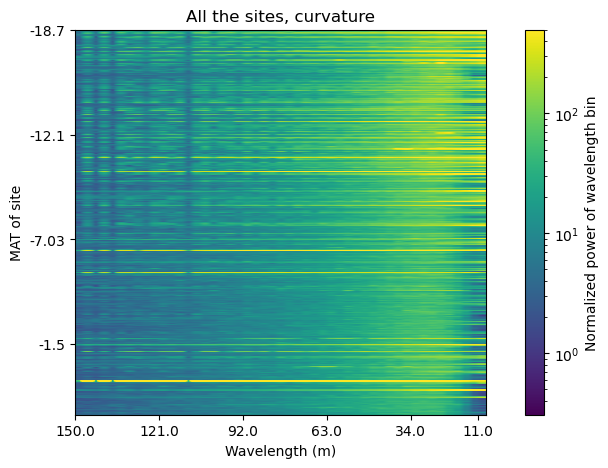

In [242]:
fig, ax = plt.subplots(figsize=(10,5))
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in mat_sorted_list:
    if data[site]['curv_norm_bin_max'].size != 0:    
        array_list.append(data[site]['curv_norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)

from matplotlib import colors 
im = ax.imshow(array, extent=[0,len(data[id_list[0]]['bin_center']),len(shedventory.sort_values(by='mat_mean')['mat_mean'].values), 0], aspect=0.05, norm = colors.LogNorm(
vmax=5e2,
),
        
          )
ax.set_ylabel('MAT of site')
ax.set_xlabel('Wavelength (m)')
ax.set_title('All the sites, curvature')

ax.set_xticks([0, 10, 20, 30, 40, 48])
ax.set_xticklabels(np.round(1/np.array([data[id_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()]),0));

ax.set_yticks([0,250,500,750])
ax.set_yticklabels((np.round(shedventory.sort_values(by='mat_mean')['mat_mean'].values,2)[int(tick)] for tick in ax.get_yticks()));

cbar = plt.colorbar(im, ax=ax, label='Normalized power of wavelength bin')

plt.savefig('figs/heatmap_of_10s_powers_curvature.pdf', bbox_inches='tight')

In [166]:
# means_list = []
# for site in mat_sorted_list:
#     if data[site]['curv_norm_bin_max'].size != 0:    
#         means_slice = data[site]['curv_norm_bin_max'][35:47]
#         means_list.append(np.nanmean(means_slice))
#     else:
#         print(f'{site} is empty')
# means = np.array(means_list)

# fig, ax = plt.subplots()
# ax.scatter(shedventory.sort_values(by='mat_mean')['mat_mean'].values, means, alpha=0.6)
# ax.set_yscale('log')
# ax.set_title(f'Average power for wavelengths 20-50 m')
# ax.set_xlabel('MAT (C) for site')
# ax.set_ylabel('Average normalized power')

In [167]:
# means_list = []
# for site in relief_tundra_sorted_list:
#     if id_dict[site]['curv_norm_bin_max'].size != 0:    
#         means_slice = id_dict[site]['curv_norm_bin_max'][35:47]
#         means_list.append(np.nanmean(means_slice))
#     else:
#         print(f'{site} is empty')
# means = np.array(means_list)

# fig, ax = plt.subplots()
# ax.scatter(shedventory.loc[shedventory['cluster']==2].sort_values(by='relief')['relief'].values, means, alpha=0.6)
# ax.set_yscale('log')
# ax.set_title(f'Average power for wavelengths 20-50 m')
# ax.set_xlabel('Relief (m) for site')
# ax.set_ylabel('Average normalized power')

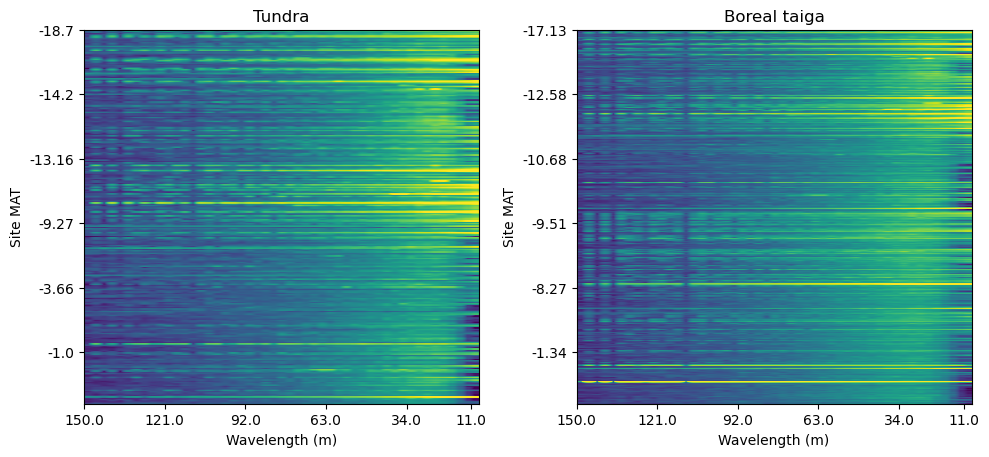

In [276]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,2,figsize=(10,5))
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in mat_tundra_sorted_list:
    if data[site]['curv_norm_bin_max'].size != 0:    
        array_list.append(data[site]['curv_norm_bin_max'])
    else:
        print(f'{site} is empty')
tundra_array = np.array(array_list)

for site in mat_boreal_sorted_list:
    if data[site]['curv_norm_bin_max'].size != 0:    
        array_list.append(data[site]['curv_norm_bin_max'])
    else:
        print(f'{site} is empty')
boreal_array = np.array(array_list)

from matplotlib import colors 
im = ax[0].imshow(tundra_array, extent=[0,len(data[id_list[0]]['bin_center']),len(shedventory.loc[shedventory['cluster']==2].sort_values(by='mat_mean')['mat_mean'].values),0],
           aspect=0.16, 
            norm = colors.LogNorm(
               vmin=1e0,
               vmax=1e3
           )
           )
ax[0].set_ylabel('Site MAT')
ax[0].set_xlabel('Wavelength (m)')
ax[0].set_title('Tundra')

ax[0].set_xticks([0, 10, 20, 30, 40, 48])
ax[0].set_xticklabels(np.round(1/np.array([data[id_list[0]]['bin_center'][int(tick)] for tick in ax[0].get_xticks()]),0));

ax[0].set_yticks([0, 50, 100, 150, 200, 250])
ax[0].set_yticklabels((np.round(shedventory.loc[shedventory['cluster']==2].sort_values(by='mat_mean')['mat_mean'].values,2)[int(tick)] for tick in ax[0].get_yticks()));

ax[1].imshow(boreal_array, extent=[0,len(data[id_list[0]]['bin_center']),len(shedventory.loc[shedventory['cluster']==2].sort_values(by='mat_mean')['mat_mean'].values),0],
           aspect=0.16, 
           norm = colors.LogNorm(
               vmin=1e0,
               vmax=1e3
           )
           )
ax[1].set_ylabel('Site MAT')
ax[1].set_xlabel('Wavelength (m)')
ax[1].set_title('Boreal taiga')

ax[1].set_xticks([0, 10, 20, 30, 40, 48])
ax[1].set_xticklabels(np.round(1/np.array([data[id_list[0]]['bin_center'][int(tick)] for tick in ax[0].get_xticks()]),0));

ax[1].set_yticks([0, 50, 100, 150, 200, 250])
ax[1].set_yticklabels((np.round(shedventory.loc[shedventory['cluster']==1].sort_values(by='mat_mean')['mat_mean'].values,2)[int(tick)] for tick in ax[1].get_yticks()));

fig.tight_layout()

# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('right', size='5%', pad=0.05)

# fig.colorbar(im, cax=cax, orientation='vertical')

# fig.colorbar(im, cax=cax,
#             #   label='Normalized power of wavelength bin',
#                 orientation='vertical')

plt.savefig('figs/tundra_vs_taiga.pdf', bbox_inches='tight')

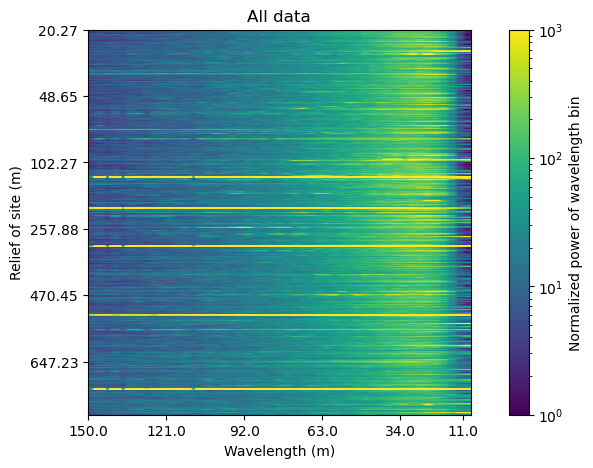

In [257]:
fig, ax = plt.subplots(figsize=(10,5))
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in relief_sorted_list:
    if data[site]['norm_bin_max'].size != 0:    
        array_list.append(data[site]['norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)

from matplotlib import colors 
ax.imshow(array, extent=[0,len(data[id_list[0]]['bin_center']),len(shedventory.loc[shedventory['cluster']==2].sort_values(by='relief')['relief'].values),0],
           aspect=0.17,
                        norm = colors.LogNorm(
               vmin=1e0,
               vmax=2e2
           )
)
ax.set_ylabel('Relief of site (m)')
ax.set_xlabel('Wavelength (m)')
ax.set_title('All data')

ax.set_xticks([0, 10, 20, 30, 40, 48])
ax.set_xticklabels(np.round(1/np.array([data[id_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()]),0));

ax.set_yticks([0, 50, 100, 150, 200, 250])
ax.set_yticklabels((np.round(shedventory.loc[shedventory['cluster']==2].sort_values(by='relief')['relief'].values,2)[int(tick)] for tick in ax.get_yticks()));
cbar = plt.colorbar(im, ax=ax, label='Normalized power of wavelength bin')

plt.savefig('figs/heatmap_of_10s_powers_relief.pdf', bbox_inches='tight')

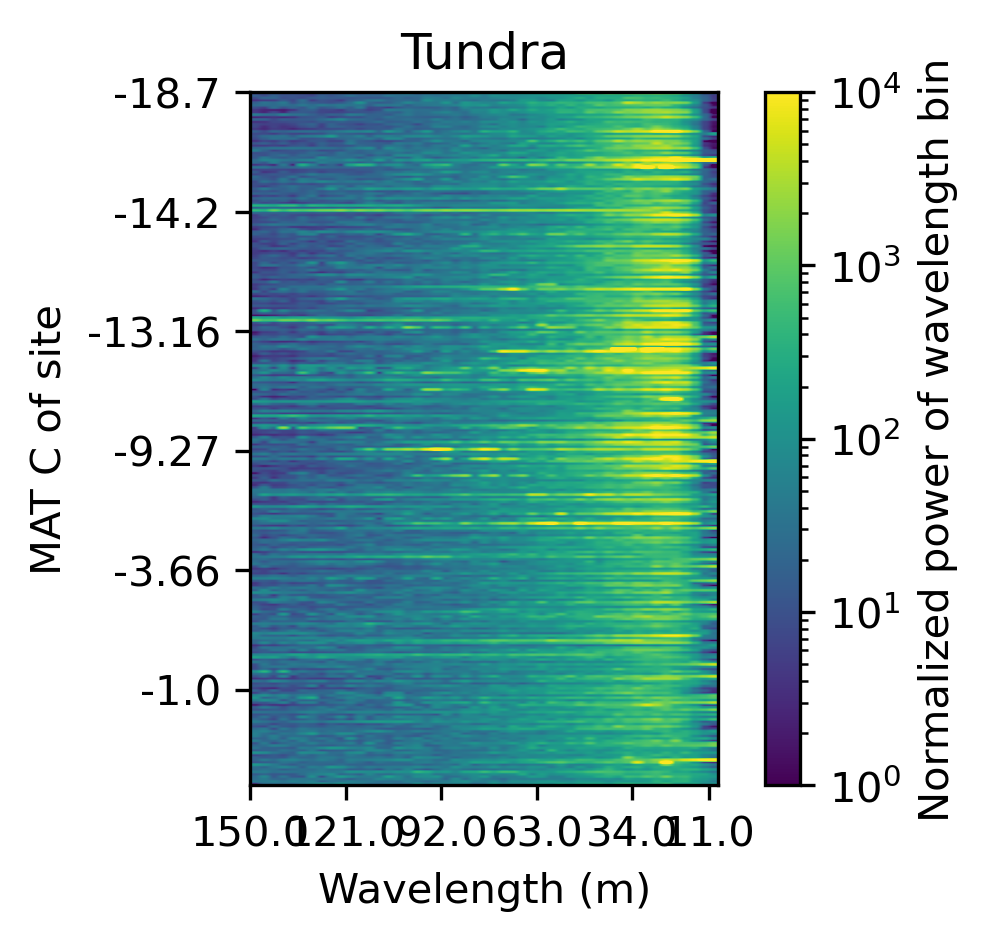

In [303]:
fig, ax = plt.subplots(figsize=(4,3), dpi=300)
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in relief_tundra_sorted_list:
    if data[site]['norm_bin_max'].size != 0:    
        array_list.append(data[site]['norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)

from matplotlib import colors 
ax.imshow(array, extent=[0,len(data[id_list[0]]['bin_center']),len(shedventory.loc[shedventory['cluster']==2].sort_values(by='mat_mean')['mat_mean'].values),0],
           aspect=0.25,
                        norm = colors.LogNorm(
               vmin=1e0,
               vmax=2e2
           )
)
ax.set_ylabel('MAT C of site')
ax.set_xlabel('Wavelength (m)')
ax.set_title('Tundra')

ax.set_xticks([0, 10, 20, 30, 40, 48])
ax.set_xticklabels(np.round(1/np.array([data[id_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()]),0));

ax.set_yticks([0, 50, 100, 150, 200, 250])
ax.set_yticklabels((np.round(shedventory.loc[shedventory['cluster']==2].sort_values(by='mat_mean')['mat_mean'].values,2)[int(tick)] for tick in ax.get_yticks()));
cbar = plt.colorbar(im, ax=ax, label='Normalized power of wavelength bin')

plt.savefig('figs/heatmap_of_10s_powers_mat_tundra.pdf', bbox_inches='tight')

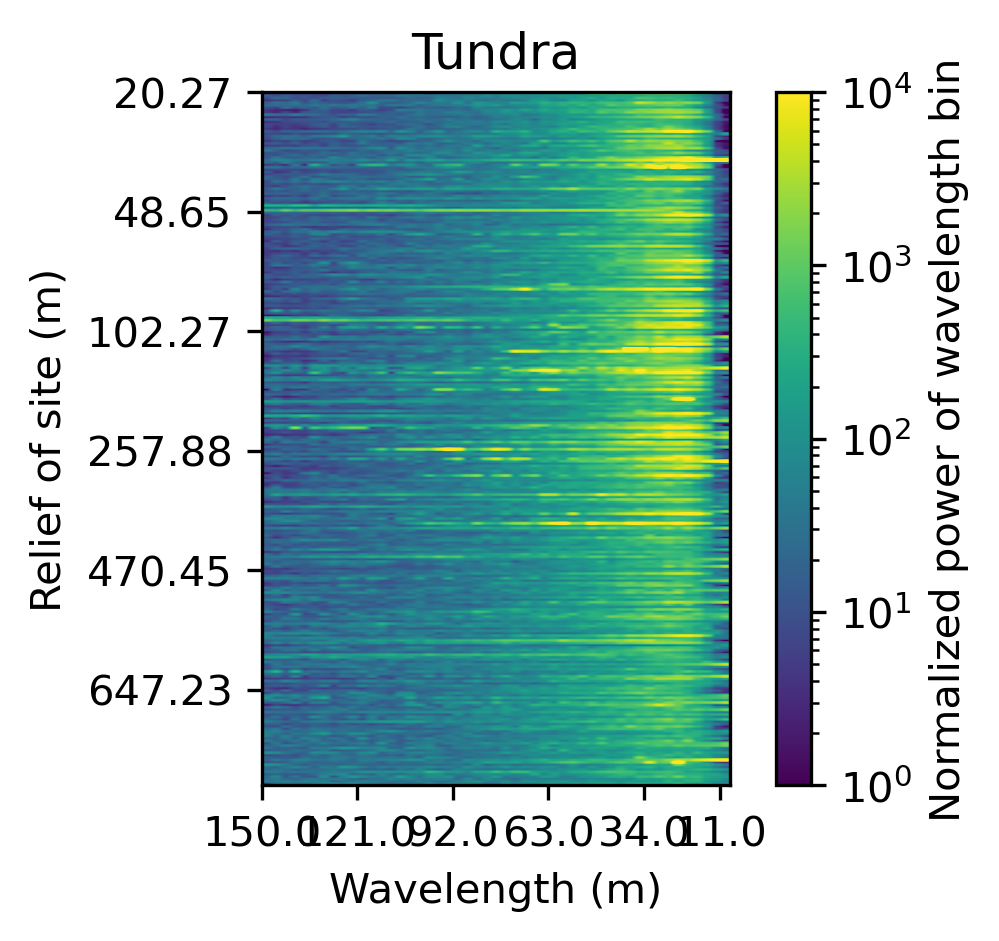

In [302]:
fig, ax = plt.subplots(figsize=(4,3), dpi=300)
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in relief_tundra_sorted_list:
    if data[site]['norm_bin_max'].size != 0:    
        array_list.append(data[site]['norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)

from matplotlib import colors 
ax.imshow(array, extent=[0,len(data[id_list[0]]['bin_center']),len(shedventory.loc[shedventory['cluster']==2].sort_values(by='relief')['relief'].values),0],
           aspect=0.25,
                        norm = colors.LogNorm(
               vmin=1e0,
               vmax=2e2
           )
)
ax.set_ylabel('Relief of site (m)')
ax.set_xlabel('Wavelength (m)')
ax.set_title('Tundra')

ax.set_xticks([0, 10, 20, 30, 40, 48])
ax.set_xticklabels(np.round(1/np.array([data[id_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()]),0));

ax.set_yticks([0, 50, 100, 150, 200, 250])
ax.set_yticklabels((np.round(shedventory.loc[shedventory['cluster']==2].sort_values(by='relief')['relief'].values,2)[int(tick)] for tick in ax.get_yticks()));
cbar = plt.colorbar(im, ax=ax, label='Normalized power of wavelength bin')

plt.savefig('figs/heatmap_of_10s_powers_relief_tundra.pdf', bbox_inches='tight')

In [174]:
# means_list = []
# for site in mat_sorted_list:
#     if id_dict[site]['curv_norm_bin_max'].size != 0:    
#         means_slice = id_dict[site]['curv_norm_bin_max'][35:47]
#         means_list.append(np.nanmean(means_slice))
#     else:
#         print(f'{site} is empty')
# means = np.array(means_list)

# fig, ax = plt.subplots()
# ax.scatter(shedventory.sort_values(by='mat_mean')['mat_mean'].values, means, alpha=0.6)
# ax.set_yscale('log')
# ax.set_title(f'Average power for wavelengths 20-50 m')
# ax.set_xlabel('MAT (C) for site')
# ax.set_ylabel('Average normalized power')

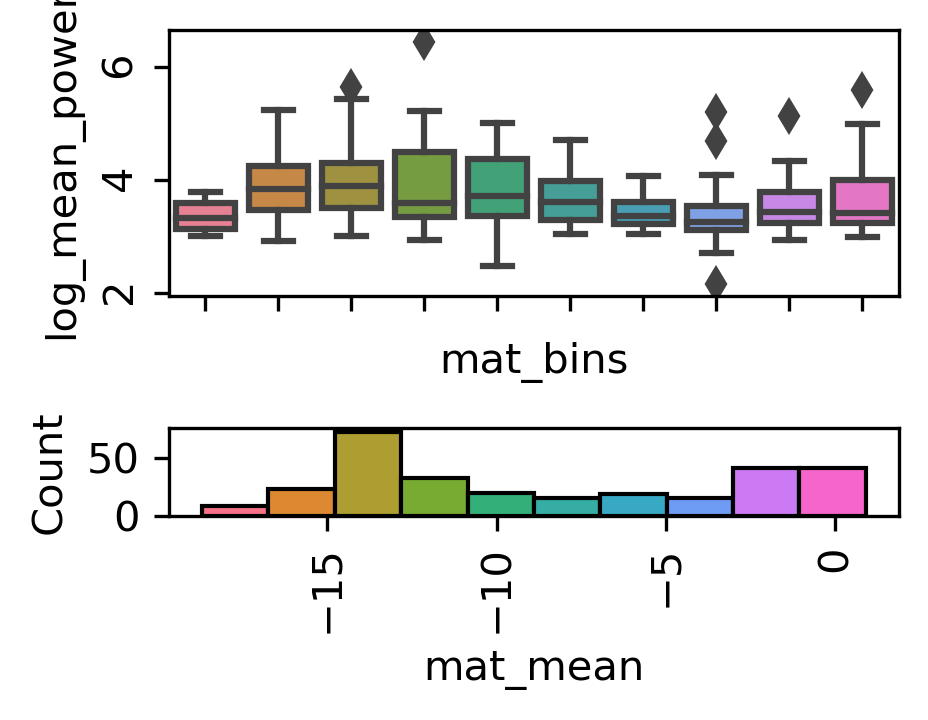

In [294]:
means_list = []
for site in mat_tundra_sorted_list:
    if data[site]['norm_bin_max'].size != 0:    
        means_slice = data[site]['norm_bin_max'][35:47]
        means_list.append(np.nanmean(means_slice))
    else:
        print(f'{site} is empty')
means = np.array(means_list)

lil_test=shedventory.loc[shedventory['cluster']==2].sort_values(by='mat_mean')
lil_test['mat_mean'] = np.round(lil_test['mat_mean'].values,1)
lil_test['mat_bins']=pd.cut(lil_test['mat_mean'], bins=10)
lil_test['mean_power']=means
lil_test['log_mean_power']=np.log(lil_test['mean_power'])
# lil_test['log_mean_power']=np.round(lil_test['log_mean_power'], 2)

fig, ax = plt.subplots(2,1, figsize=(3.5,2.5), gridspec_kw={'height_ratios': [3, 1]}, dpi=300)
sns.boxplot(data=lil_test, y='log_mean_power', x='mat_bins', ax=ax[0],
            palette="husl"
            # showfliers=False,
            )
ax[0].set_yscale('log')
ax[0].set_xticklabels(labels=[])
ax[0].set_yticklabels(labels=ax[0].get_yticklabels(), rotation=90)
sns.histplot(data=lil_test,  x='mat_mean', ax=ax[1],
             palette='husl',
            
            )
# ax[0].set_yscale('log')
for i, _ in enumerate(ax[1].patches):
    ax[1].patches[i].set_facecolor(sns.color_palette("husl", len(ax[1].patches))[i])
# ax[1].set_yticklabels(labels=ax[0].get_yticklabels(), rotation=90)
ax[1].set_xticklabels(labels=ax[1].get_xticklabels(), rotation=90)
fig.tight_layout()
ax[0].set_yscale('linear')  # Set y-axis to log scale
# ax[0].set_ylim(0.1,5)
# ax[0].yaxis.set_minor_formatter(ScalarFormatter())
plt.savefig('figs/mat_boxplots.pdf', bbox_inches='tight')

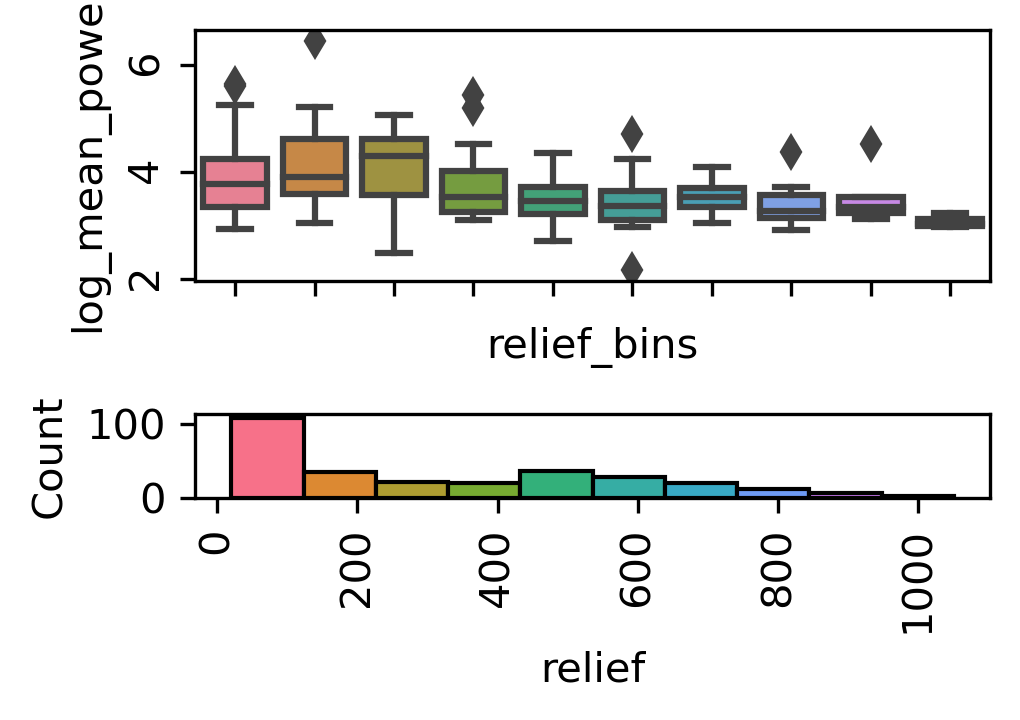

In [296]:
means_list = []
for site in relief_tundra_sorted_list:
    if data[site]['norm_bin_max'].size != 0:    
        means_slice = data[site]['norm_bin_max'][35:47]
        means_list.append(np.nanmean(means_slice))
    else:
        print(f'{site} is empty')
means = np.array(means_list)

lil_test=shedventory.loc[shedventory['cluster']==2].sort_values(by='relief')
lil_test['relief_bins']=pd.cut(lil_test['relief'], bins=10)
lil_test['mean_power']=means
lil_test['log_mean_power']=np.log(lil_test['mean_power'])

fig, ax = plt.subplots(2,1, figsize=(3.5,2.5), gridspec_kw={'height_ratios': [3, 1]}, dpi=300)
sns.boxplot(data=lil_test, y='log_mean_power', x='relief_bins', ax=ax[0],
            palette="husl"
            # showfliers=False,
            )
ax[0].set_yscale('log')
ax[0].set_xticklabels(labels=[])
ax[0].set_yticklabels(labels=ax[0].get_yticklabels(), rotation=90)
sns.histplot(data=lil_test,  x='relief', ax=ax[1],
             palette='husl',
            
            )
# ax[0].set_yscale('log')
for i, _ in enumerate(ax[1].patches):
    ax[1].patches[i].set_facecolor(sns.color_palette("husl", len(ax[1].patches))[i])
# ax[1].set_yticklabels(labels=ax[0].get_yticklabels(), rotation=90)
ax[1].set_xticklabels(labels=ax[1].get_xticklabels(), rotation=90)

from matplotlib.ticker import ScalarFormatter
ax[0].yaxis.set_major_formatter(ScalarFormatter())
ax[0].set_yscale('linear')  # Set y-axis to log scale

fig.tight_layout()

plt.savefig('figs/relief_boxplots.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'All the sites')

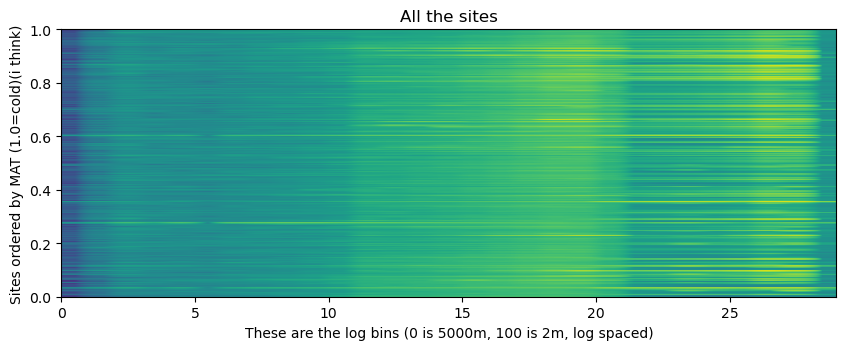

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in mat_sorted_list:
    if data[site]['norm_bin_max'].size != 0:    
        array_list.append(data[site]['norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)

from matplotlib import colors 
ax.imshow(array, extent=[0,29,0,1], aspect=10, norm = colors.LogNorm())
ax.set_ylabel('Sites ordered by MAT (1.0=cold)(i think)')
ax.set_xlabel('These are the log bins (0 is 5000m, 100 is 2m, log spaced)')
ax.set_title('All the sites')

[Text(2, 0, '1333.0'),
 Text(11, 0, '133.0'),
 Text(20, 0, '13.0'),
 Text(28, 0, '2.0')]

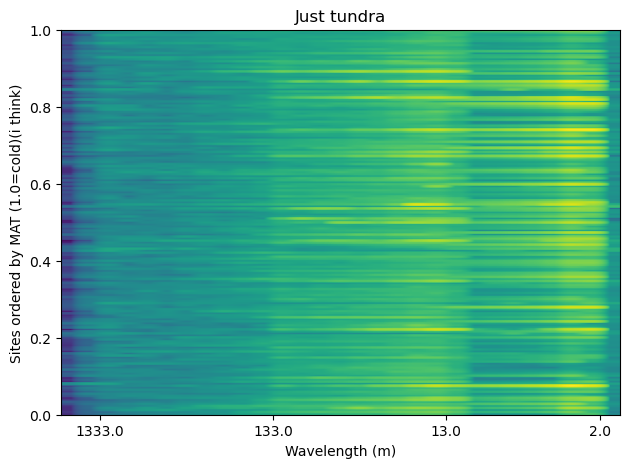

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in mat_tundra_sorted_list:
    if data[site]['norm_bin_max'].size != 0:    
        array_list.append(data[site]['norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)

from matplotlib import colors 
ax.imshow(array, extent=[0,29,0,1], aspect=20, norm = colors.LogNorm())
ax.set_ylabel('Sites ordered by MAT (1.0=cold)(i think)')
ax.set_xlabel('Wavelength (m)')
ax.set_title('Just tundra')

ax.set_xticks([2,11,20,28,])
ax.set_xticklabels(np.round(1/np.array([data[mat_sorted_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()]),0))
# ax.set_xticklabels(['1000', '100', '10', '2'])

[Text(2, 0, '1333.0'),
 Text(11, 0, '133.0'),
 Text(20, 0, '13.0'),
 Text(28, 0, '2.0')]

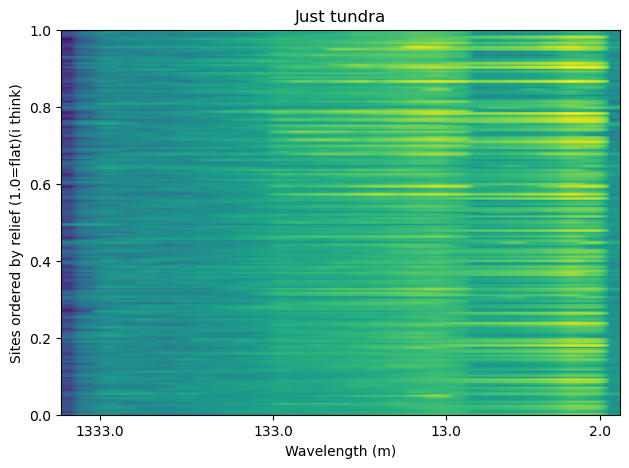

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in relief_tundra_sorted_list:
    if data[site]['norm_bin_max'].size != 0:    
        array_list.append(data[site]['norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)

from matplotlib import colors 
ax.imshow(array, extent=[0,29,0,1], aspect=20, norm = colors.LogNorm())
ax.set_ylabel('Sites ordered by relief (1.0=flat)(i think)')
ax.set_xlabel('Wavelength (m)')
ax.set_title('Just tundra')

ax.set_xticks([2,11,20,28,])
ax.set_xticklabels(np.round(1/np.array([data[mat_sorted_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()]),0))
# ax.set_xticklabels(['1000', '100', '10', '2'])

In [ ]:
1/(data[mat_sorted_list[0]]['bin_center'])

array([4.44444444e+03, 2.40000000e+03, 1.33333333e+03, 9.47368421e+02,
       8.47058824e+02, 7.46666667e+02, 6.46153846e+02, 5.45454545e+02,
       4.44444444e+02, 3.42857143e+02, 2.40000000e+02, 1.33333333e+02,
       9.47368421e+01, 8.47058824e+01, 7.46666667e+01, 6.46153846e+01,
       5.45454545e+01, 4.44444444e+01, 3.42857143e+01, 2.40000000e+01,
       1.33333333e+01, 9.47368421e+00, 8.47058824e+00, 7.46666667e+00,
       6.46153846e+00, 5.45454545e+00, 4.44444444e+00, 3.42857143e+00,
       2.40000000e+00])

In [ ]:
ax.get_xticks()

array([ 0.,  5., 10., 15., 20., 25., 30.])

In [ ]:
data[mat_sorted_list[0]]['bin_center']

array([2.25000000e-04, 4.16666667e-04, 7.50000000e-04, 1.05555556e-03,
       1.18055556e-03, 1.33928571e-03, 1.54761905e-03, 1.83333333e-03,
       2.25000000e-03, 2.91666667e-03, 4.16666667e-03, 7.50000000e-03,
       1.05555556e-02, 1.18055556e-02, 1.33928571e-02, 1.54761905e-02,
       1.83333333e-02, 2.25000000e-02, 2.91666667e-02, 4.16666667e-02,
       7.50000000e-02, 1.05555556e-01, 1.18055556e-01, 1.33928571e-01,
       1.54761905e-01, 1.83333333e-01, 2.25000000e-01, 2.91666667e-01,
       4.16666667e-01])

In [ ]:
1/np.array([data[mat_sorted_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()[:-1]])

array([4444.44444444,  746.66666667,  240.        ,   64.61538462,
         13.33333333,    5.45454545])

Text(0, 0.5, 'Normalized power, bin max\nArcticDEM elevation')

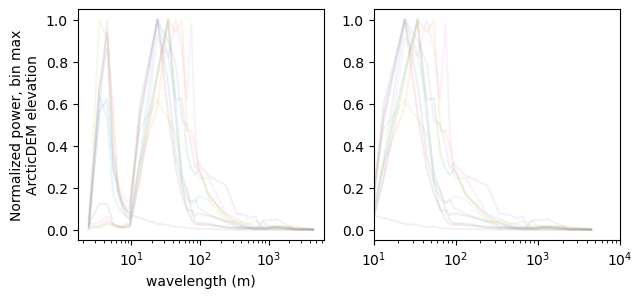

In [ ]:
# fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=100)
# for site, data_dict in id_dict.items():
#     try:
#         ax[0].semilogx(1/data_dict['bin_center'], (data_dict['norm_bin_max']/data_dict['norm_bin_max'].max()), 
#                     #    label=site,
#                     alpha=0.1)
#         ax[1].semilogx(1/data_dict['bin_center'], (data_dict['norm_bin_max']/data_dict['norm_bin_max'].max()), 
#                     #    label=site,
#                     alpha=0.1)
#     except ValueError:
#         pass
#     # ax[0].legend()
#     ax[1].set_xlim(1e1,1e4)
#     # ax[1].set_ylim(0,100)

# ax[0].set_xlabel('wavelength (m)')
# ax[0].set_ylabel('Normalized power, bin max\nArcticDEM elevation')

In [ ]:
# fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=100)
# for site, data_dict in id_dict.items():
#     try:
#         ax[0].semilogx(1/data_dict['curv_bin_center'], (data_dict['curv_norm_bin_max']/data_dict['curv_norm_bin_max'].max()), 
#                     #    label=site,
#                     alpha=0.1)
#         ax[1].semilogx(1/data_dict['curv_bin_center'], (data_dict['curv_norm_bin_max']/data_dict['curv_norm_bin_max'].max()), 
#                     #    label=site,
#                     alpha=0.1)
#     except ValueError:
#         pass
#     # ax[0].legend()
#     ax[1].set_xlim(1e1,1e3)
#     # ax[1].set_ylim(0,100)

# ax[0].set_xlabel('wavelength (m)')
# ax[0].set_ylabel('Normalized power, bin max\nArcticDEM elevation')

In [ ]:
id_dict_copy = id_dict

In [ ]:
data_list = []
for id in id_list:
    try:
        norm_power_1e3 = id_dict_copy[id]['norm_bin_max'][1/(id_dict_copy[id]['bin_center']) > 1e3][id_dict_copy[id]['norm_bin_max'][1/(id_dict_copy[id]['bin_center']) > 1e3].argmax()]
        wavelength_1e3 = 1/id_dict_copy[id]['bin_center'][1/(id_dict_copy[id]['bin_center']) > 1e3][id_dict_copy[id]['norm_bin_max'][1/(id_dict_copy[id]['bin_center']) > 1e3].argmax()]

        wavelength_1e2 = 1/id_dict_copy[id]['bin_center'][(1/(id_dict_copy[id]['bin_center']) < 1e3) & (1/(id_dict_copy[id]['bin_center']) > 1e2)][id_dict_copy[id]['norm_bin_max'][(1/(id_dict_copy[id]['bin_center']) < 1e3) & (1/(id_dict_copy[id]['bin_center']) > 1e2)].argmax()]
        norm_power_1e2 = id_dict_copy[id]['norm_bin_max'][(1/(id_dict_copy[id]['bin_center']) < 1e3) & (1/(id_dict_copy[id]['bin_center']) > 1e2)].max()
                                                                
        wavelength_1e1 = 1/id_dict_copy[id]['bin_center'][(1/(id_dict_copy[id]['bin_center']) < 1e2) & (1/(id_dict_copy[id]['bin_center']) > 1e1)][id_dict_copy[id]['norm_bin_max'][(1/(id_dict_copy[id]['bin_center']) < 1e2) & (1/(id_dict_copy[id]['bin_center']) > 1e1)].argmax()]
        norm_power_1e1 = id_dict_copy[id]['norm_bin_max'][(1/(id_dict_copy[id]['bin_center']) < 1e2) & (1/(id_dict_copy[id]['bin_center']) > 1e1)].max()
                                                                
        norm_power_1e0 = id_dict_copy[id]['norm_bin_max'][1/(id_dict_copy[id]['bin_center']) < 1e1][id_dict_copy[id]['norm_bin_max'][1/(id_dict_copy[id]['bin_center']) < 1e1].argmax()]
        wavelength_1e0 = 1/id_dict_copy[id]['bin_center'][1/(id_dict_copy[id]['bin_center']) < 1e1][id_dict_copy[id]['norm_bin_max'][1/(id_dict_copy[id]['bin_center']) < 1e1].argmax()]

        data = [id, wavelength_1e3, norm_power_1e3, wavelength_1e2, norm_power_1e2, wavelength_1e1, norm_power_1e1, wavelength_1e0, norm_power_1e0]
        data_list.append(data)
    
    except ValueError:
        print(f'{id} is empty!')
        pass


8100006660 is empty!
3100349510 is empty!
2100232610 is empty!


In [ ]:
df = pd.DataFrame(data=data_list, columns=['HYBAS_ID', 'wavelength_1e3', 'norm_power_1e3', 'wavelength_1e2', 'norm_power_1e2', 'wavelength_1e1', 'norm_power_1e1', 'wavelength_1e0', 'norm_power_1e0'])

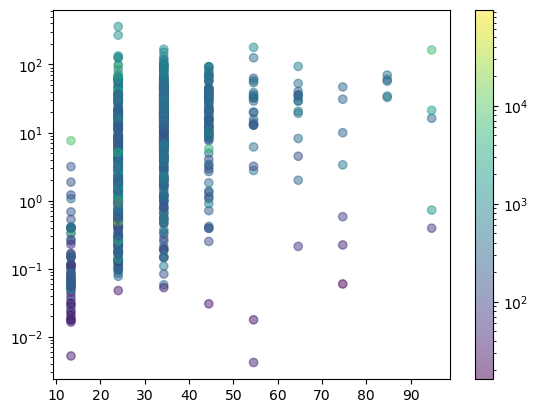

In [ ]:
from matplotlib import colors 
plt.scatter(df['wavelength_1e1'], (df['norm_power_1e1']/df['norm_power_1e0']), c=df['norm_power_1e1'],
            alpha=0.5,
              norm = colors.LogNorm())
plt.colorbar()
plt.yscale('log')

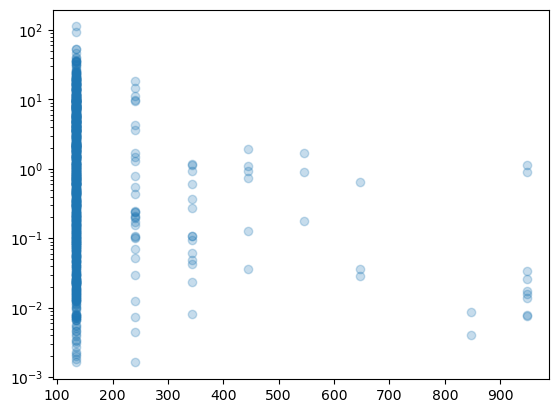

In [ ]:
plt.scatter(df['wavelength_1e2'], (df['norm_power_1e2']/df['norm_power_1e0']), alpha=0.25)
plt.yscale('log')

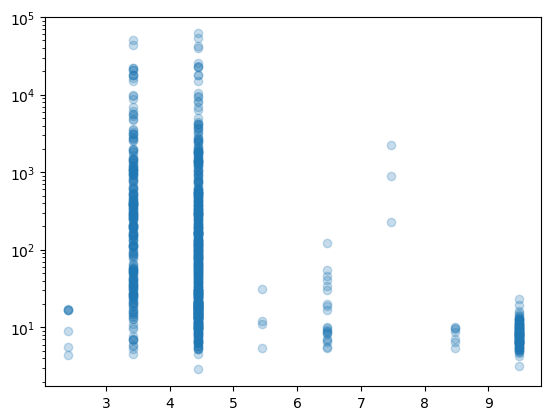

In [ ]:
plt.scatter(df['wavelength_1e0'], df['norm_power_1e0'], alpha=0.25)
plt.yscale('log')

In [ ]:
df.to_csv('spectra_wavelength_powers.csv')

# Compare to watershed trends

In [ ]:
df = pd.read_csv('spectra_wavelength_powers.csv')

In [ ]:
d1 = pd.read_csv('veg_cluster_sheds.csv').drop('Unnamed: 0', axis=1)
d2 = pd.read_csv('noperm_veg_cluster_sheds.csv').drop('Unnamed: 0', axis=1)

In [ ]:
cluster = pd.concat([d1, d2])
shedventory = pd.read_csv('shedventory_2.0.1_GIA.csv')

In [ ]:
shedventory = pd.merge(cluster, shedventory, on='HYBAS_ID')
# shedventory

In [ ]:
shedventory = pd.merge(df, shedventory, on='HYBAS_ID')
# shedventory

In [ ]:
relief_array = np.append(np.linspace(-1,400,num=3), [np.inf])
shedventory['relief_bin'] = pd.cut(shedventory['relief'], bins=relief_array)

In [ ]:
simplified_dict = {
    'Sporadic':'Patchy',
    'Isolated':'Patchy', 
    'Discontinuous':'Extensive',
    'Continuous':'Extensive',
    'No permafrost':'No permafrost'
}

shedventory['simple'] = shedventory['EXTENT'].map(simplified_dict)

In [ ]:
shedventory = shedventory.drop_duplicates()

In [ ]:
# shedventory.loc[(shedventory['cluster']==1) & (shedventory['wavelength_1e1']>50)].sort_values('norm_power_1e1', ascending=False)[0:10]

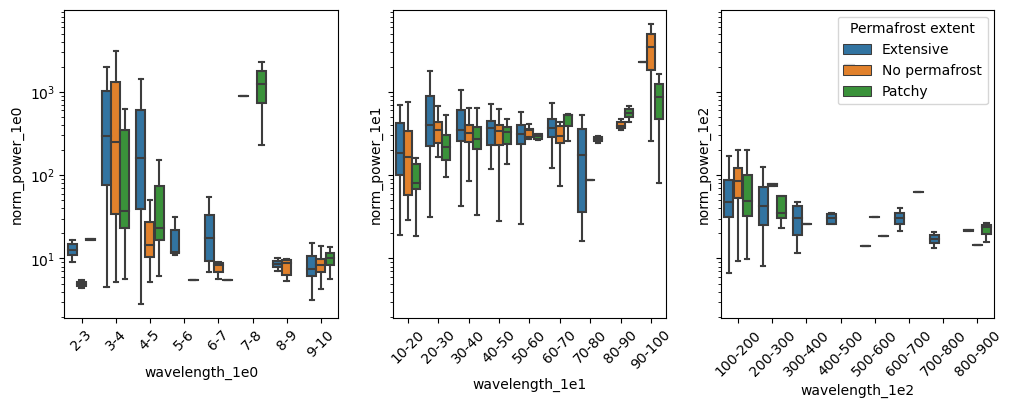

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
sns.boxplot(data=shedventory, x=np.round(shedventory['wavelength_1e0'],0), y=shedventory['norm_power_1e0'], hue='simple', showfliers=False, ax=ax[0])
sns.boxplot(data=shedventory, x=np.round(shedventory['wavelength_1e1'],0), y=shedventory['norm_power_1e1'], hue='simple', showfliers=False, ax=ax[1])
sns.boxplot(data=shedventory, x=np.round(shedventory['wavelength_1e2'],0), y=shedventory['norm_power_1e2'], hue='simple', showfliers=False, ax=ax[2])
ax[0].get_legend().remove()
ax[0].set_xticklabels(labels=['2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10'], rotation=45)
ax[1].get_legend().remove()
ax[1].set_xticklabels(labels=['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'], rotation=45)
ax[2].get_legend().set_title('Permafrost extent')
ax[2].set_xticklabels(labels=['100-200', '200-300', '300-400', '400-500', '500-600', '600-700', '700-800', '800-900' ], rotation=45)
ax[0].set_yscale('log')

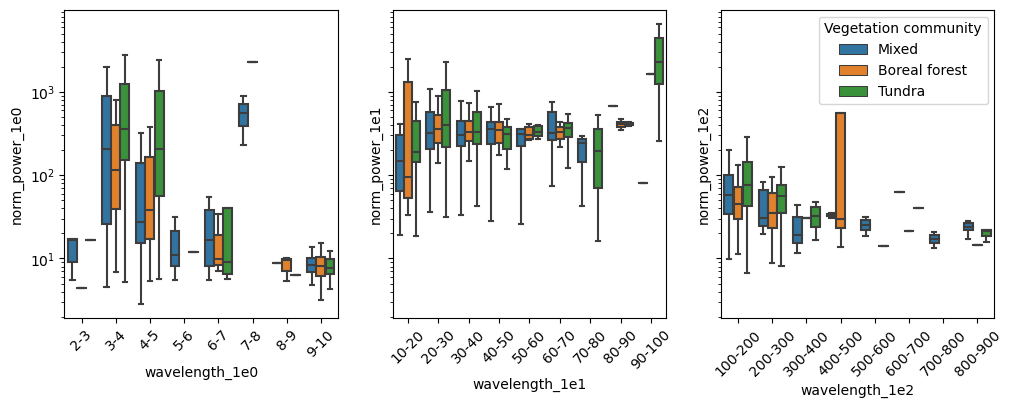

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
sns.boxplot(data=shedventory, x=np.round(shedventory['wavelength_1e0'],0), y=shedventory['norm_power_1e0'], hue='cluster', showfliers=False, ax=ax[0])
sns.boxplot(data=shedventory, x=np.round(shedventory['wavelength_1e1'],0), y=shedventory['norm_power_1e1'], hue='cluster', showfliers=False, ax=ax[1])
sns.boxplot(data=shedventory, x=np.round(shedventory['wavelength_1e2'],0), y=shedventory['norm_power_1e2'], hue='cluster', showfliers=False, ax=ax[2])
ax[0].get_legend().remove()
ax[0].set_xticklabels(labels=['2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10'], rotation=45)
ax[1].get_legend().remove()
ax[1].set_xticklabels(labels=['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'], rotation=45)
legend_handles, _= ax[2].get_legend_handles_labels()
ax[2].legend(legend_handles, ['Mixed','Boreal forest','Tundra']) 
ax[2].get_legend().set_title('Vegetation community')
ax[2].set_xticklabels(labels=['100-200', '200-300', '300-400', '400-500', '500-600', '600-700', '700-800', '800-900' ], rotation=45)
ax[0].set_yscale('log')

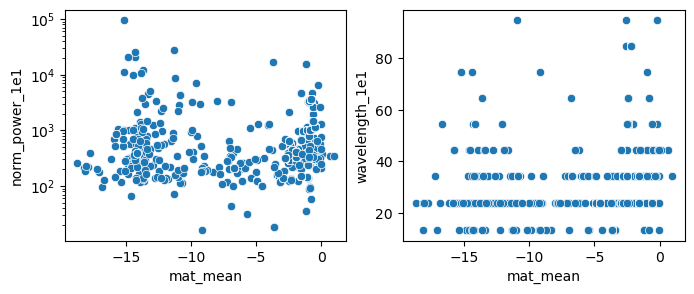

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
sns.scatterplot(data=shedventory.loc[shedventory['cluster']==2], x='mat_mean', y='norm_power_1e1', ax=ax[0])
sns.scatterplot(data=shedventory.loc[shedventory['cluster']==2], x='mat_mean', y='wavelength_1e1', ax=ax[1])
ax[0].set_yscale('log')

In [ ]:
shedventory['log_np_1e1'] = np.log(shedventory['norm_power_1e1'])
shedventory['log_np_1e2'] = np.log(shedventory['norm_power_1e2'])
shedventory['log_np_1e3'] = np.log(shedventory['norm_power_1e3'])

<Axes: xlabel='relief', ylabel='log_np_1e1'>

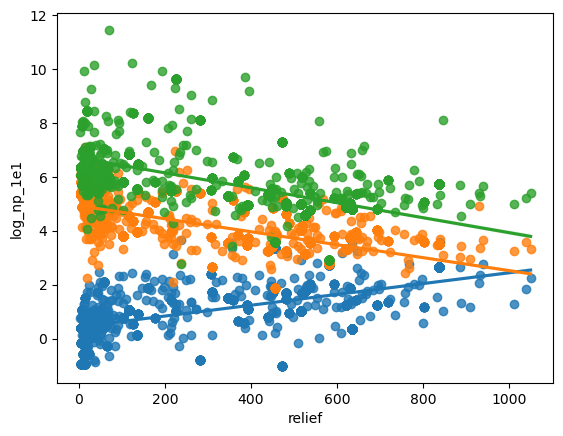

In [ ]:
fig, ax = plt.subplots()
sns.regplot(data=shedventory.loc[shedventory['cluster']==2], x='relief', 
            # y='norm_power_1e3', 
            y='log_np_1e3', 
            # edgecolor='k', 
            label='1e3')
sns.regplot(data=shedventory.loc[shedventory['cluster']==2], x='relief', 
            # y='norm_power_1e2',
                #  edgecolor='k',
                y='log_np_1e2', 
                 label='1e2')
sns.regplot(data=shedventory.loc[shedventory['cluster']==2], x='relief', 
            # y='norm_power_1e1',
                #  edgecolor='k',
                y='log_np_1e1', 
                 label='1e1')
# ax.set_yscale('log')

<Axes: xlabel='relief', ylabel='log_np_1e1'>

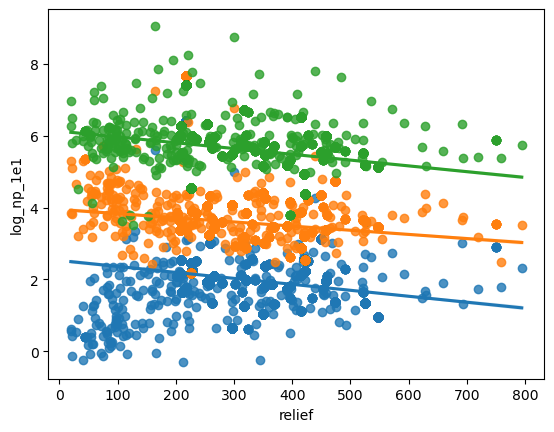

In [ ]:
fig, ax = plt.subplots()
sns.regplot(data=shedventory.loc[(shedventory['cluster']==1) & (shedventory['relief']<800)], x='relief', 
            # y='norm_power_1e3', 
            y='log_np_1e3', 
            # edgecolor='k', 
            label='1e3')
sns.regplot(data=shedventory.loc[(shedventory['cluster']==1) & (shedventory['relief']<800)], x='relief', 
            # y='norm_power_1e2',
                #  edgecolor='k',
                y='log_np_1e2', 
                 label='1e2')
sns.regplot(data=shedventory.loc[(shedventory['cluster']==1) & (shedventory['relief']<800)], x='relief', 
            # y='norm_power_1e1',
                #  edgecolor='k',
                y='log_np_1e1', 
                 label='1e1')
# ax.set_yscale('log')